# GARCH + LSTM Hybrid Model for Volatility Forecasting

This notebook implements a hybrid approach combining:
1. **GARCH Model**: Captures volatility clustering and conditional heteroskedasticity
2. **LSTM Neural Network**: Learns complex temporal patterns from volatility predictions

The hybrid model uses GARCH to generate volatility forecasts, then feeds these as features into an LSTM network for improved predictions.

In [118]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from arch import arch_model
import warnings
import random

warnings.filterwarnings('ignore')

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


## 1. Data Preparation

In [119]:
# Data Download Configuration
# S&P 500: January 1, 2002 to December 31, 2023
# Bitcoin: January 1, 2015 to December 31, 2023

# Define date ranges
sp500_start = "2002-01-01"
sp500_end = "2023-12-31"
bitcoin_start = "2015-01-01"
bitcoin_end = "2023-12-31"

print("Downloading S&P 500 data...")
# Download S&P 500 data (^GSPC is the Yahoo Finance ticker)
sp500_data = yf.download("^GSPC", start=sp500_start, end=sp500_end, progress=False)

print("Downloading Bitcoin data...")
# Download Bitcoin data (BTC-USD is the Yahoo Finance ticker)
bitcoin_data = yf.download("BTC-USD", start=bitcoin_start, end=bitcoin_end, progress=False)

print("Downloading EURUSD data...")
# Download EURUSD data
eurusd_data = yf.download("EURUSD=X", start="2009-08-11", end="2019-08-11", progress=False)

# Display basic information about downloaded data
print(f"\nS&P 500 Data Shape: {sp500_data.shape}")
print(f"S&P 500 Date Range: {sp500_data.index.min()} to {sp500_data.index.max()}")
print(f"Total S&P 500 observations: {len(sp500_data)}")

print(f"\nBitcoin Data Shape: {bitcoin_data.shape}")
print(f"Bitcoin Date Range: {bitcoin_data.index.min()} to {bitcoin_data.index.max()}")
print(f"Total Bitcoin observations: {len(bitcoin_data)}")

print(f"\nEURUSD Data Shape: {eurusd_data.shape}")
print(f"EURUSD Date Range: {eurusd_data.index.min()} to {eurusd_data.index.max()}")
print(f"Total EURUSD observations: {len(eurusd_data)}")



S&P 500 Data Shape: (5537, 5)
S&P 500 Date Range: 2002-01-02 00:00:00 to 2023-12-29 00:00:00
Total S&P 500 observations: 5537

Bitcoin Data Shape: (3286, 5)
Bitcoin Date Range: 2015-01-01 00:00:00 to 2023-12-30 00:00:00
Total Bitcoin observations: 3286

EURUSD Data Shape: (2604, 5)
EURUSD Date Range: 2009-08-11 00:00:00 to 2019-08-09 00:00:00
Total EURUSD observations: 2604


In [120]:
# Calculate log returns
sp500_data['Log_Returns'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
bitcoin_data['Log_Returns'] = np.log(bitcoin_data['Close'] / bitcoin_data['Close'].shift(1))
eurusd_data['Log_Returns'] = np.log(eurusd_data['Close'] / eurusd_data['Close'].shift(1))

# Calculate realized volatility (squared returns as proxy)
sp500_data['Realized_Volatility'] = sp500_data['Log_Returns'] ** 2
bitcoin_data['Realized_Volatility'] = bitcoin_data['Log_Returns'] ** 2
eurusd_data['Realized_Volatility'] = eurusd_data['Log_Returns'] ** 2

# Drop NaN values
sp500_clean = sp500_data.dropna()
bitcoin_clean = bitcoin_data.dropna()
eurusd_clean = eurusd_data.dropna()

print("\n=== Data Summary ===")
print(f"S&P 500 clean data: {len(sp500_clean)} observations")
print(f"Bitcoin clean data: {len(bitcoin_clean)} observations")
print(f"EURUSD clean data: {len(eurusd_clean)} observations")
print(f"\nS&P 500 Log Returns - Mean: {sp500_clean['Log_Returns'].mean():.6f}, Std: {sp500_clean['Log_Returns'].std():.6f}")
print(f"Bitcoin Log Returns - Mean: {bitcoin_clean['Log_Returns'].mean():.6f}, Std: {bitcoin_clean['Log_Returns'].std():.6f}")
print(f"EURUSD Log Returns - Mean: {eurusd_clean['Log_Returns'].mean():.6f}, Std: {eurusd_clean['Log_Returns'].std():.6f}")


=== Data Summary ===
S&P 500 clean data: 5536 observations
Bitcoin clean data: 3285 observations
EURUSD clean data: 2603 observations

S&P 500 Log Returns - Mean: 0.000256, Std: 0.012245
Bitcoin Log Returns - Mean: 0.001491, Std: 0.037394
EURUSD Log Returns - Mean: -0.000090, Std: 0.005766


## 2. GARCH Model Implementation

We'll use GARCH(1,1) which is the most common specification for financial volatility.

In [121]:
def fit_garch_model(returns, p=1, q=1):
    """
    Fit GARCH model to returns data
    
    Parameters:
    returns: pandas Series of log returns
    p: GARCH lag order
    q: ARCH lag order
    
    Returns:
    fitted model
    """
    # Multiply by 100 to scale the returns (common practice for GARCH estimation)
    returns_scaled = returns * 100
    
    # Specify GARCH model
    model = arch_model(returns_scaled, vol='Garch', p=p, q=q, rescale=False)
    
    # Fit model
    model_fit = model.fit(disp='off')
    
    return model_fit

def get_garch_volatility(model_fit, returns):
    """
    Extract conditional volatility from fitted GARCH model
    """
    # Get conditional volatility (already in percentage scale)
    conditional_vol = model_fit.conditional_volatility / 100
    
    return conditional_vol

In [122]:
# Fit GARCH models for both datasets
print("\n=== Fitting GARCH Models ===")
print("\nFitting GARCH(1,1) for S&P 500...")
sp500_garch = fit_garch_model(sp500_clean['Log_Returns'])
print(sp500_garch.summary())

print("\n" + "="*80)
print("\nFitting GARCH(1,1) for Bitcoin...")
bitcoin_garch = fit_garch_model(bitcoin_clean['Log_Returns'])
print(bitcoin_garch.summary())

print("\n" + "="*80)
print("\nFitting GARCH(1,1) for EURUSD...")
eurusd_garch = fit_garch_model(eurusd_clean['Log_Returns'])
print(eurusd_garch.summary())


=== Fitting GARCH Models ===

Fitting GARCH(1,1) for S&P 500...
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Log_Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7498.89
Distribution:                  Normal   AIC:                           15005.8
Method:            Maximum Likelihood   BIC:                           15032.3
                                        No. Observations:                 5536
Date:                Fri, Dec 12 2025   Df Residuals:                     5535
Time:                        01:31:52   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------

In [123]:
# Extract GARCH conditional volatility
sp500_clean['GARCH_Volatility'] = get_garch_volatility(sp500_garch, sp500_clean['Log_Returns'])
bitcoin_clean['GARCH_Volatility'] = get_garch_volatility(bitcoin_garch, bitcoin_clean['Log_Returns'])
eurusd_clean['GARCH_Volatility'] = get_garch_volatility(eurusd_garch, eurusd_clean['Log_Returns'])

print("\n=== GARCH Volatility Statistics ===")
print(f"S&P 500 GARCH Volatility - Mean: {sp500_clean['GARCH_Volatility'].mean():.6f}, Std: {sp500_clean['GARCH_Volatility'].std():.6f}")
print(f"Bitcoin GARCH Volatility - Mean: {bitcoin_clean['GARCH_Volatility'].mean():.6f}, Std: {bitcoin_clean['GARCH_Volatility'].std():.6f}")
print(f"EURUSD GARCH Volatility - Mean: {eurusd_clean['GARCH_Volatility'].mean():.6f}, Std: {eurusd_clean['GARCH_Volatility'].std():.6f}")


=== GARCH Volatility Statistics ===
S&P 500 GARCH Volatility - Mean: 0.010440, Std: 0.006176
Bitcoin GARCH Volatility - Mean: 0.036201, Std: 0.014206
EURUSD GARCH Volatility - Mean: 0.005608, Std: 0.001440


## 3. LSTM Model Implementation

We'll create LSTM networks that use GARCH volatility predictions as input features to predict future volatility.

In [124]:
def create_lstm_sequences(data, lookback=60):
    """
    Create sequences for LSTM training
    
    Parameters:
    data: array of values to create sequences from
    lookback: number of time steps to look back
    
    Returns:
    X: input sequences
    y: target values
    """
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

def build_lstm_model(lookback, units=50, dropout=0.2):
    """
    Build LSTM model architecture
    """
    model = Sequential()
    
    # First LSTM layer with return sequences
    model.add(LSTM(units=units, return_sequences=True, input_shape=(lookback, 1)))
    model.add(Dropout(dropout))
    
    # Second LSTM layer
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout))
    
    # Third LSTM layer
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout))
    
    # Output layer
    model.add(Dense(units=1))
    
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [125]:
def prepare_garch_lstm_data(data, train_split=0.8, lookback=60):
    """
    Prepare data for GARCH-LSTM hybrid model
    """
    # Use GARCH volatility as input feature
    garch_vol = data['GARCH_Volatility'].values.reshape(-1, 1)
    realized_vol = data['Realized_Volatility'].values.reshape(-1, 1)
    
    # Scale the data
    scaler_garch = MinMaxScaler(feature_range=(0, 1))
    scaler_realized = MinMaxScaler(feature_range=(0, 1))
    
    garch_vol_scaled = scaler_garch.fit_transform(garch_vol)
    realized_vol_scaled = scaler_realized.fit_transform(realized_vol)
    
    # Create sequences
    X, y = create_lstm_sequences(garch_vol_scaled, lookback)
    
    # Split into train and test
    train_size = int(len(X) * train_split)
    
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    
    # Reshape for LSTM [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Get corresponding realized volatility for comparison
    y_realized_train = realized_vol_scaled[lookback:lookback+train_size]
    y_realized_test = realized_vol_scaled[lookback+train_size:]
    
    return X_train, X_test, y_train, y_test, y_realized_train, y_realized_test, scaler_garch, scaler_realized

## 4. Train GARCH-LSTM Hybrid Models

In [126]:
# Prepare data for S&P 500
print("\n=== Preparing S&P 500 Data for GARCH-LSTM ===")
lookback = 60
X_train_sp, X_test_sp, y_train_sp, y_test_sp, y_real_train_sp, y_real_test_sp, scaler_garch_sp, scaler_real_sp = prepare_garch_lstm_data(
    sp500_clean, train_split=0.8, lookback=lookback
)

print(f"Training set size: {X_train_sp.shape[0]}")
print(f"Test set size: {X_test_sp.shape[0]}")
print(f"Lookback period: {lookback} days")

# Build and train S&P 500 model
print("\n=== Training S&P 500 GARCH-LSTM Model ===")
model_sp = build_lstm_model(lookback=lookback, units=50, dropout=0.2)
print(model_sp.summary())

history_sp = model_sp.fit(
    X_train_sp, y_train_sp,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


=== Preparing S&P 500 Data for GARCH-LSTM ===
Training set size: 4380
Test set size: 1096
Lookback period: 60 days

=== Training S&P 500 GARCH-LSTM Model ===


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_51 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_52 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 11s 47ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.0010 - val_loss: 8.7997e-04
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 9.1896e-04 - val_loss: 7.9765e-04
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 8.2221e-04 - val_loss: 7.8484e-04
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 7.9879e-04 - val_loss: 6.7210e-04
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 7.6746e-04 - val_loss: 6.1978e-04
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 7.2543e-04 - val_loss: 5.7730e-04
Epoch 9/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 7.3152e-04 - val_loss: 5.9651e-04
Epoch 10/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 6.9179e-04 - val_loss: 5.3323e-04
Epoch 11/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 6

In [127]:
# Prepare data for Bitcoin
print("\n=== Preparing Bitcoin Data for GARCH-LSTM ===")
X_train_btc, X_test_btc, y_train_btc, y_test_btc, y_real_train_btc, y_real_test_btc, scaler_garch_btc, scaler_real_btc = prepare_garch_lstm_data(
    bitcoin_clean, train_split=0.8, lookback=lookback
)

print(f"Training set size: {X_train_btc.shape[0]}")
print(f"Test set size: {X_test_btc.shape[0]}")
print(f"Lookback period: {lookback} days")

# Build and train Bitcoin model
print("\n=== Training Bitcoin GARCH-LSTM Model ===")
model_btc = build_lstm_model(lookback=lookback, units=50, dropout=0.2)
print(model_btc.summary())

history_btc = model_btc.fit(
    X_train_btc, y_train_btc,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


=== Preparing Bitcoin Data for GARCH-LSTM ===
Training set size: 2580
Test set size: 645
Lookback period: 60 days

=== Training Bitcoin GARCH-LSTM Model ===


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_54 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_56 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0086 - val_loss: 0.0013
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0042 - val_loss: 0.0014
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0017 - val_loss: 9.2580e-04
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0017 - val_loss: 8.3198e-04
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0014 - val_loss: 7.6697e-04
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0013 - val_loss: 7.3100e-04
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [128]:
# Prepare data for EURUSD
print("\n=== Preparing EURUSD Data for GARCH-LSTM ===")
X_train_eurusd, X_test_eurusd, y_train_eurusd, y_test_eurusd, y_real_train_eurusd, y_real_test_eurusd, scaler_garch_eurusd, scaler_real_eurusd = prepare_garch_lstm_data(
    eurusd_clean, train_split=0.8, lookback=lookback
)

print(f"Training set size: {X_train_eurusd.shape[0]}")
print(f"Test set size: {X_test_eurusd.shape[0]}")
print(f"Lookback period: {lookback} days")

# Build and train EURUSD model
print("\n=== Training EURUSD GARCH-LSTM Model ===")
model_eurusd = build_lstm_model(lookback=lookback, units=50, dropout=0.2)
print(model_eurusd.summary())

history_eurusd = model_eurusd.fit(
    X_train_eurusd, y_train_eurusd,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


=== Preparing EURUSD Data for GARCH-LSTM ===
Training set size: 2034
Test set size: 509
Lookback period: 60 days

=== Training EURUSD GARCH-LSTM Model ===


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_57 (LSTM)                  │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_58 (LSTM)                  │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_59 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 0.0655 - val_loss: 0.0023
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0072 - val_loss: 0.0019
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0063 - val_loss: 0.0021
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0059 - val_loss: 0.0022
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0055 - val_loss: 0.0016
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0058 - val_loss: 0.0015
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0051 - val_loss: 0.0014
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss

## 5. Model Predictions and Performance Metrics

In [129]:
# Make predictions for S&P 500
print("\n=== Making Predictions for S&P 500 ===")
y_pred_train_sp = model_sp.predict(X_train_sp)
y_pred_test_sp = model_sp.predict(X_test_sp)

# Inverse transform predictions to original scale
y_pred_train_sp_orig = scaler_garch_sp.inverse_transform(y_pred_train_sp)
y_pred_test_sp_orig = scaler_garch_sp.inverse_transform(y_pred_test_sp.reshape(-1, 1))
y_train_sp_orig = scaler_garch_sp.inverse_transform(y_train_sp.reshape(-1, 1))
y_test_sp_orig = scaler_garch_sp.inverse_transform(y_test_sp.reshape(-1, 1))

# Get realized volatility for comparison
y_real_train_sp_orig = scaler_real_sp.inverse_transform(y_real_train_sp)
y_real_test_sp_orig = scaler_real_sp.inverse_transform(y_real_test_sp)

# Calculate metrics for S&P 500
rmse_train_sp = np.sqrt(mean_squared_error(y_real_train_sp_orig, y_pred_train_sp_orig))
mae_train_sp = mean_absolute_error(y_real_train_sp_orig, y_pred_train_sp_orig)
rmse_test_sp = np.sqrt(mean_squared_error(y_real_test_sp_orig, y_pred_test_sp_orig))
mae_test_sp = mean_absolute_error(y_real_test_sp_orig, y_pred_test_sp_orig)

# Calculate GARCH-only performance for comparison
rmse_garch_train_sp = np.sqrt(mean_squared_error(y_real_train_sp_orig, y_train_sp_orig))
mae_garch_train_sp = mean_absolute_error(y_real_train_sp_orig, y_train_sp_orig)
rmse_garch_test_sp = np.sqrt(mean_squared_error(y_real_test_sp_orig, y_test_sp_orig))
mae_garch_test_sp = mean_absolute_error(y_real_test_sp_orig, y_test_sp_orig)

print("\n=== S&P 500 Performance Metrics ===")
print("\nGARCH-LSTM Hybrid Model:")
print(f"Training Set - RMSE: {rmse_train_sp:.8f}, MAE: {mae_train_sp:.8f}")
print(f"Test Set - RMSE: {rmse_test_sp:.8f}, MAE: {mae_test_sp:.8f}")
print("\nGARCH Model (Baseline):")
print(f"Training Set - RMSE: {rmse_garch_train_sp:.8f}, MAE: {mae_garch_train_sp:.8f}")
print(f"Test Set - RMSE: {rmse_garch_test_sp:.8f}, MAE: {mae_garch_test_sp:.8f}")
print("\nImprovement over GARCH:")
print(f"Test RMSE Improvement: {((rmse_garch_test_sp - rmse_test_sp) / rmse_garch_test_sp * 100):.2f}%")
print(f"Test MAE Improvement: {((mae_garch_test_sp - mae_test_sp) / mae_garch_test_sp * 100):.2f}%")


=== Making Predictions for S&P 500 ===
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

=== S&P 500 Performance Metrics ===

GARCH-LSTM Hybrid Model:
Training Set - RMSE: 0.01124175, MAE: 0.00993347
Test Set - RMSE: 0.01297758, MAE: 0.01125193

GARCH Model (Baseline):
Training Set - RMSE: 0.01147896, MAE: 0.01000530
Test Set - RMSE: 0.01339411, MAE: 0.01140869

Improvement over GARCH:
Test RMSE Improvement: 3.11%
Test MAE Improvement: 1.37%


In [130]:
# Make predictions for Bitcoin
print("\n=== Making Predictions for Bitcoin ===")
y_pred_train_btc = model_btc.predict(X_train_btc)
y_pred_test_btc = model_btc.predict(X_test_btc)

# Inverse transform predictions to original scale
y_pred_train_btc_orig = scaler_garch_btc.inverse_transform(y_pred_train_btc)
y_pred_test_btc_orig = scaler_garch_btc.inverse_transform(y_pred_test_btc.reshape(-1, 1))
y_train_btc_orig = scaler_garch_btc.inverse_transform(y_train_btc.reshape(-1, 1))
y_test_btc_orig = scaler_garch_btc.inverse_transform(y_test_btc.reshape(-1, 1))

# Get realized volatility for comparison
y_real_train_btc_orig = scaler_real_btc.inverse_transform(y_real_train_btc)
y_real_test_btc_orig = scaler_real_btc.inverse_transform(y_real_test_btc)

# Calculate metrics for Bitcoin
rmse_train_btc = np.sqrt(mean_squared_error(y_real_train_btc_orig, y_pred_train_btc_orig))
mae_train_btc = mean_absolute_error(y_real_train_btc_orig, y_pred_train_btc_orig)
rmse_test_btc = np.sqrt(mean_squared_error(y_real_test_btc_orig, y_pred_test_btc_orig))
mae_test_btc = mean_absolute_error(y_real_test_btc_orig, y_pred_test_btc_orig)

# Calculate GARCH-only performance for comparison
rmse_garch_train_btc = np.sqrt(mean_squared_error(y_real_train_btc_orig, y_train_btc_orig))
mae_garch_train_btc = mean_absolute_error(y_real_train_btc_orig, y_train_btc_orig)
rmse_garch_test_btc = np.sqrt(mean_squared_error(y_real_test_btc_orig, y_test_btc_orig))
mae_garch_test_btc = mean_absolute_error(y_real_test_btc_orig, y_test_btc_orig)

print("\n=== Bitcoin Performance Metrics ===")
print("\nGARCH-LSTM Hybrid Model:")
print(f"Training Set - RMSE: {rmse_train_btc:.8f}, MAE: {mae_train_btc:.8f}")
print(f"Test Set - RMSE: {rmse_test_btc:.8f}, MAE: {mae_test_btc:.8f}")
print("\nGARCH Model (Baseline):")
print(f"Training Set - RMSE: {rmse_garch_train_btc:.8f}, MAE: {mae_garch_train_btc:.8f}")
print(f"Test Set - RMSE: {rmse_garch_test_btc:.8f}, MAE: {mae_garch_test_btc:.8f}")
print("\nImprovement over GARCH:")
print(f"Test RMSE Improvement: {((rmse_garch_test_btc - rmse_test_btc) / rmse_garch_test_btc * 100):.2f}%")
print(f"Test MAE Improvement: {((mae_garch_test_btc - mae_test_btc) / mae_garch_test_btc * 100):.2f}%")


=== Making Predictions for Bitcoin ===
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

=== Bitcoin Performance Metrics ===

GARCH-LSTM Hybrid Model:
Training Set - RMSE: 0.03861826, MAE: 0.03629383
Test Set - RMSE: 0.03173673, MAE: 0.03069839

GARCH Model (Baseline):
Training Set - RMSE: 0.03850189, MAE: 0.03576938
Test Set - RMSE: 0.03090664, MAE: 0.02972963

Improvement over GARCH:
Test RMSE Improvement: -2.69%
Test MAE Improvement: -3.26%


In [131]:
# Make predictions for EURUSD
print("\n=== Making Predictions for EURUSD ===")
y_pred_train_eurusd = model_eurusd.predict(X_train_eurusd)
y_pred_test_eurusd = model_eurusd.predict(X_test_eurusd)

# Inverse transform predictions to original scale
y_pred_train_eurusd_orig = scaler_garch_eurusd.inverse_transform(y_pred_train_eurusd)
y_pred_test_eurusd_orig = scaler_garch_eurusd.inverse_transform(y_pred_test_eurusd.reshape(-1, 1))
y_train_eurusd_orig = scaler_garch_eurusd.inverse_transform(y_train_eurusd.reshape(-1, 1))
y_test_eurusd_orig = scaler_garch_eurusd.inverse_transform(y_test_eurusd.reshape(-1, 1))

# Get realized volatility for comparison
y_real_train_eurusd_orig = scaler_real_eurusd.inverse_transform(y_real_train_eurusd)
y_real_test_eurusd_orig = scaler_real_eurusd.inverse_transform(y_real_test_eurusd)

# Calculate metrics for Bitcoin
rmse_train_eurusd = np.sqrt(mean_squared_error(y_real_train_eurusd_orig, y_pred_train_eurusd_orig))
mae_train_eurusd = mean_absolute_error(y_real_train_eurusd_orig, y_pred_train_eurusd_orig)
rmse_test_eurusd = np.sqrt(mean_squared_error(y_real_test_eurusd_orig, y_pred_test_eurusd_orig))
mae_test_eurusd = mean_absolute_error(y_real_test_eurusd_orig, y_pred_test_eurusd_orig)

# Calculate GARCH-only performance for comparison
rmse_garch_train_eurusd = np.sqrt(mean_squared_error(y_real_train_eurusd_orig, y_train_eurusd_orig))
mae_garch_train_eurusd = mean_absolute_error(y_real_train_eurusd_orig, y_train_eurusd_orig)
rmse_garch_test_eurusd = np.sqrt(mean_squared_error(y_real_test_eurusd_orig, y_test_eurusd_orig))
mae_garch_test_eurusd = mean_absolute_error(y_real_test_eurusd_orig, y_test_eurusd_orig)

print("\n=== EURUSD Performance Metrics ===")
print("\nGARCH-LSTM Hybrid Model:")
print(f"Training Set - RMSE: {rmse_train_eurusd:.8f}, MAE: {mae_train_eurusd:.8f}")
print(f"Test Set - RMSE: {rmse_test_eurusd:.8f}, MAE: {mae_test_eurusd:.8f}")
print("\nGARCH Model (Baseline):")
print(f"Training Set - RMSE: {rmse_garch_train_eurusd:.8f}, MAE: {mae_garch_train_eurusd:.8f}")
print(f"Test Set - RMSE: {rmse_garch_test_eurusd:.8f}, MAE: {mae_garch_test_eurusd:.8f}")
print("\nImprovement over GARCH:")
print(f"Test RMSE Improvement: {((rmse_garch_test_eurusd - rmse_test_eurusd) / rmse_garch_test_eurusd * 100):.2f}%")
print(f"Test MAE Improvement: {((mae_garch_test_eurusd - mae_test_eurusd) / mae_garch_test_eurusd * 100):.2f}%")


=== Making Predictions for EURUSD ===
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

=== EURUSD Performance Metrics ===

GARCH-LSTM Hybrid Model:
Training Set - RMSE: 0.00605562, MAE: 0.00589128
Test Set - RMSE: 0.00440308, MAE: 0.00437174

GARCH Model (Baseline):
Training Set - RMSE: 0.00607031, MAE: 0.00589974
Test Set - RMSE: 0.00439198, MAE: 0.00436057

Improvement over GARCH:
Test RMSE Improvement: -0.25%
Test MAE Improvement: -0.26%


## 6. Visualizations

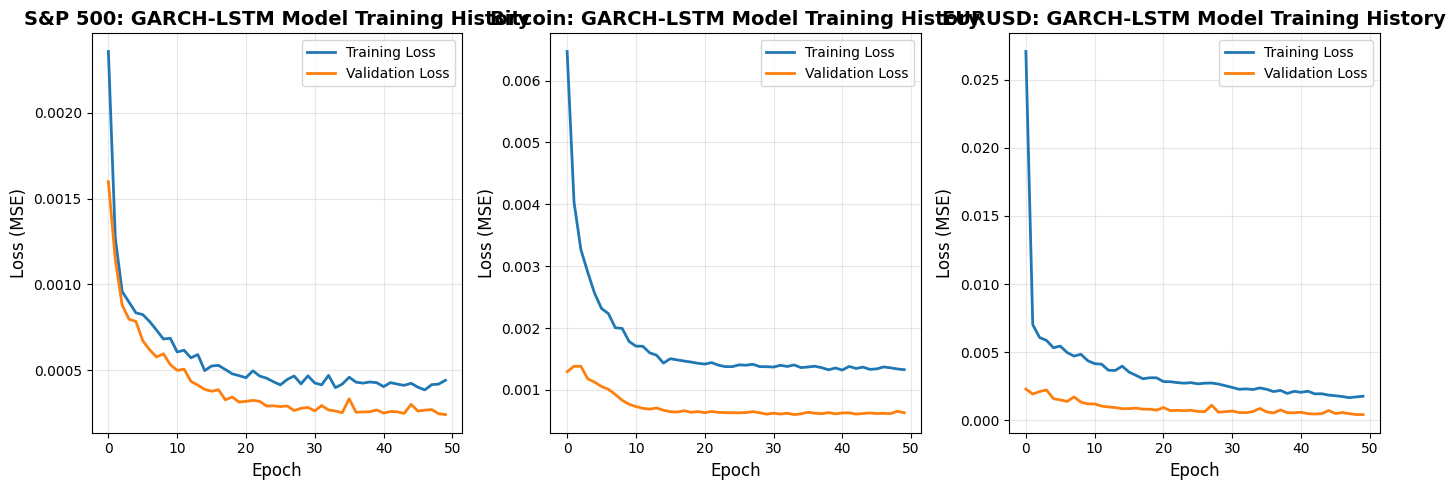

In [132]:
# Plot training history for S&P 500
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(history_sp.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_sp.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('S&P 500: GARCH-LSTM Model Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(history_btc.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_btc.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Bitcoin: GARCH-LSTM Model Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(history_eurusd.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history_eurusd.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('EURUSD: GARCH-LSTM Model Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)


plt.tight_layout()
# plt.savefig('garch_lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Training history plot saved as 'garch_lstm_training_history.png'")

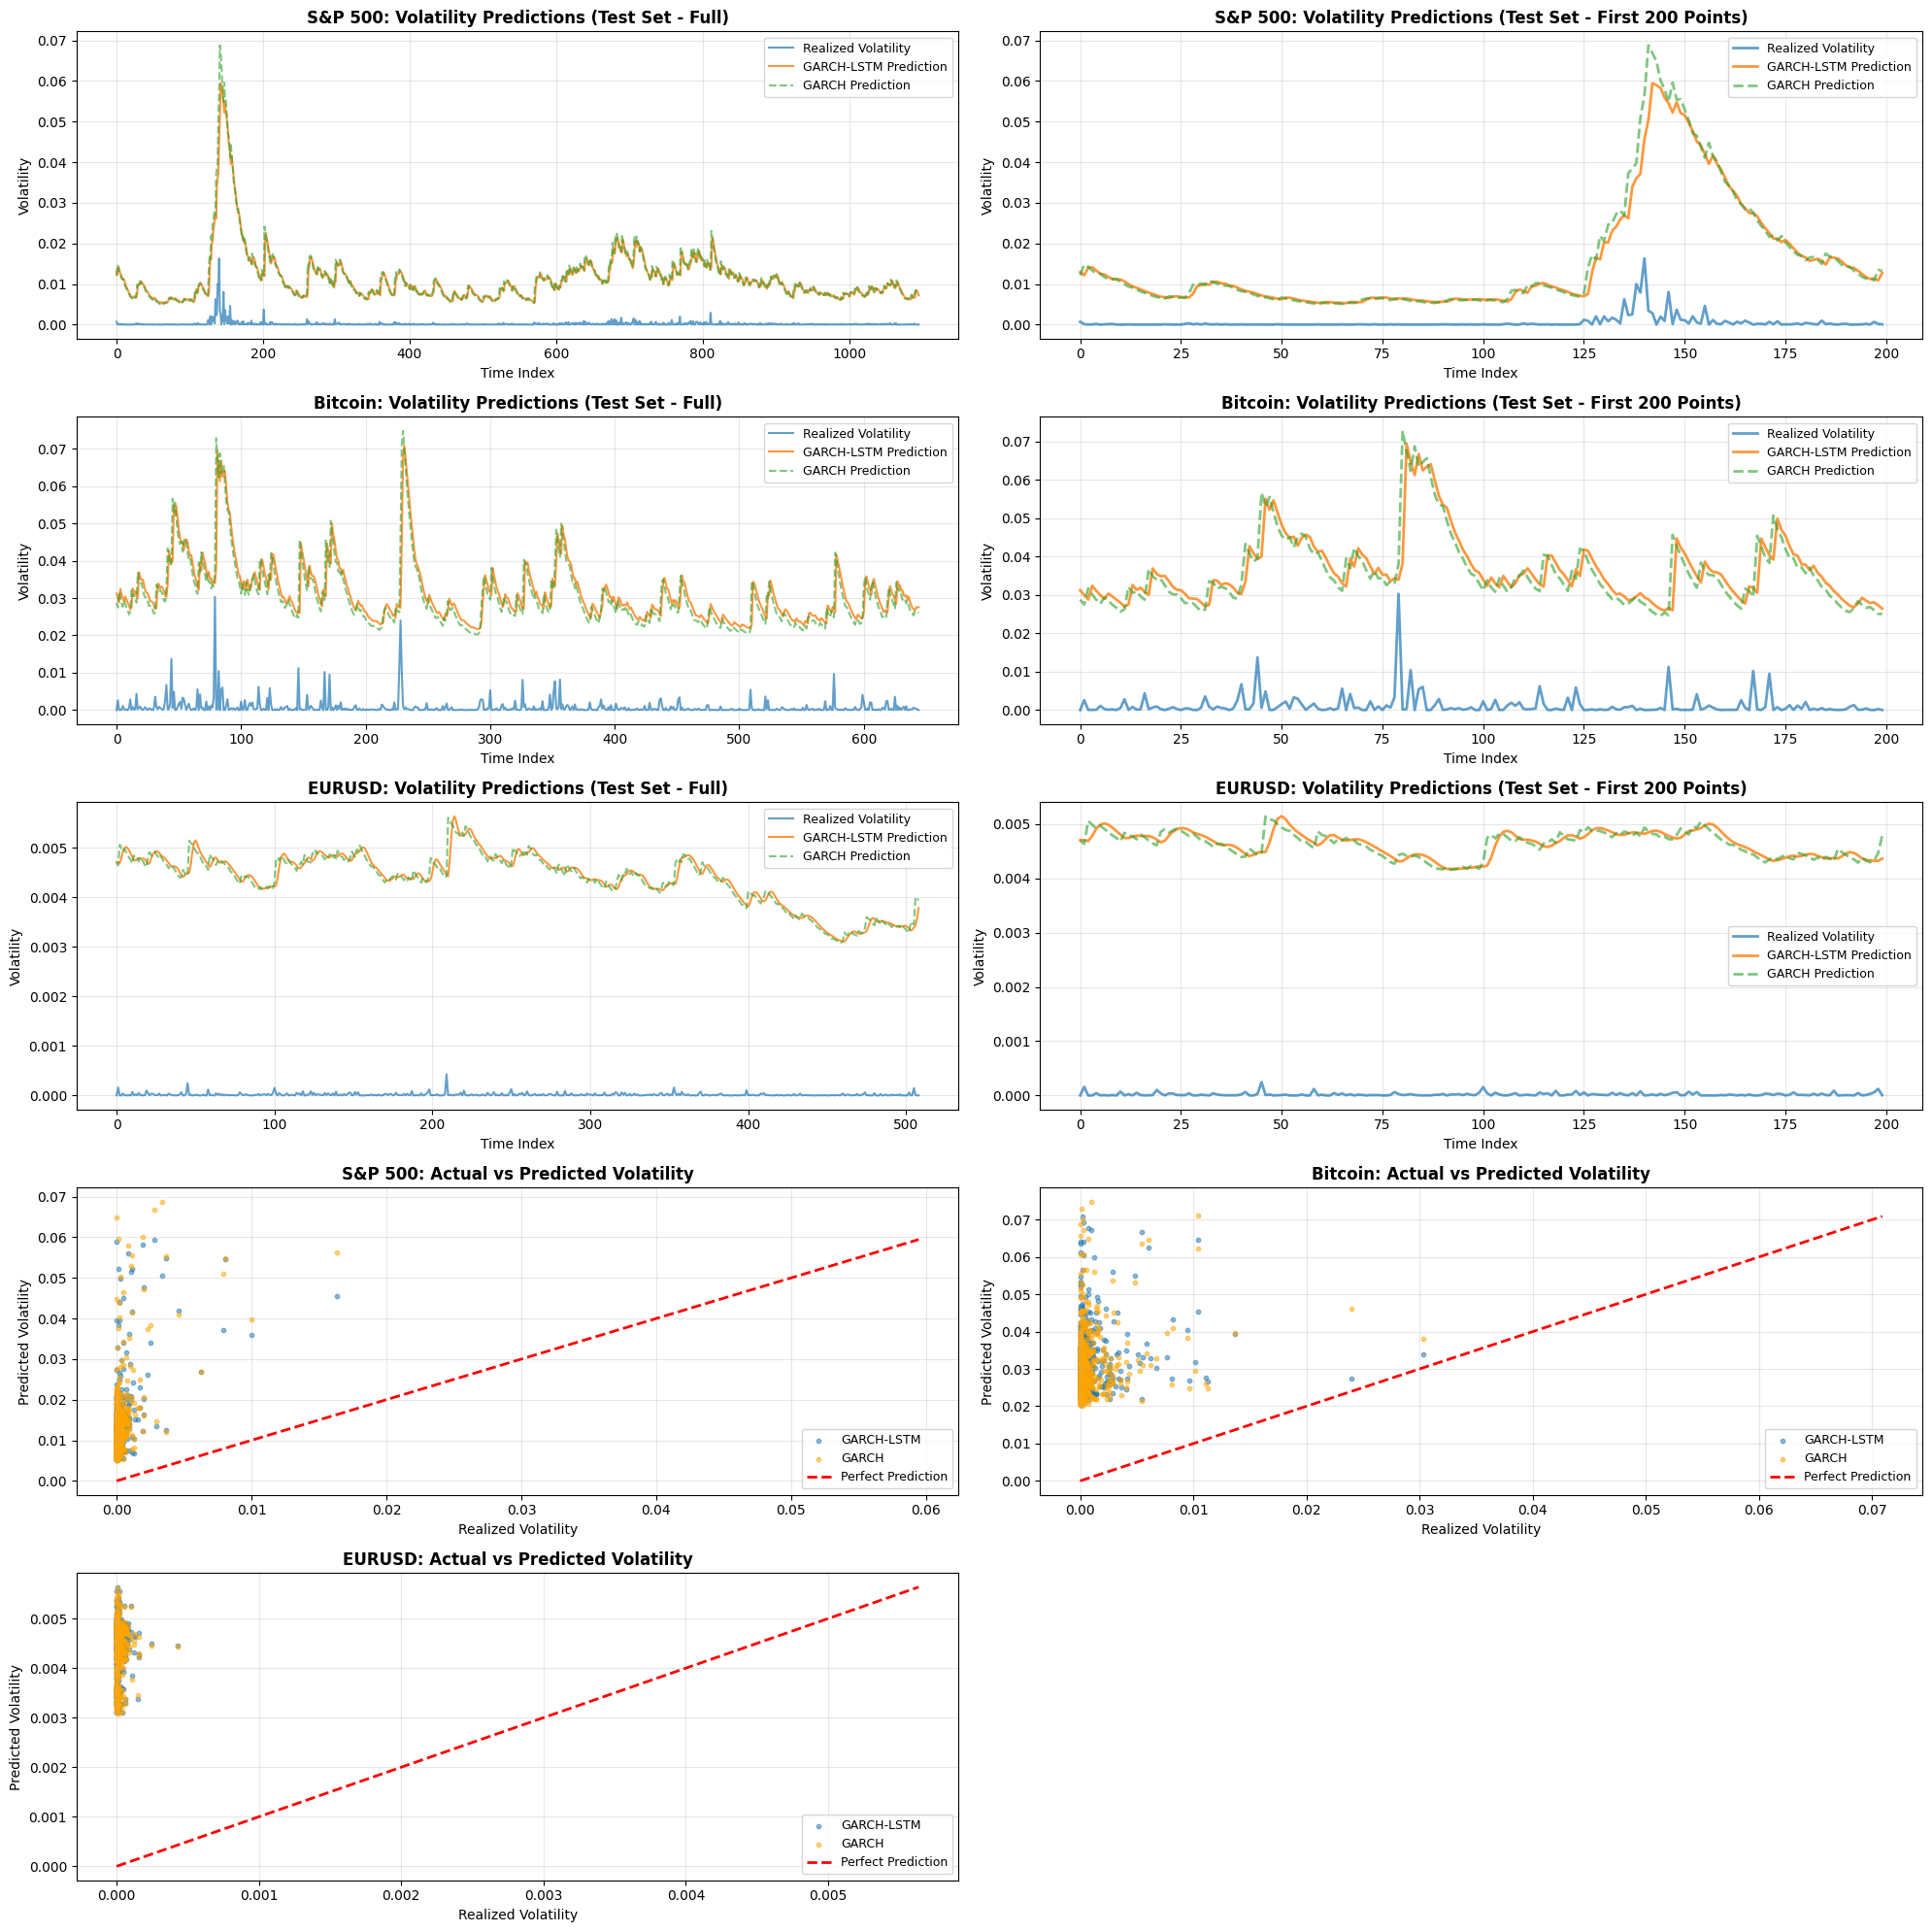

In [133]:
# Plot predictions vs actual for S&P 500
plt.figure(figsize=(20, 20))

# S&P 500 - Full Period
plt.subplot(5, 2, 1)
plt.plot(y_real_test_sp_orig, label='Realized Volatility', alpha=0.7, linewidth=1.5)
plt.plot(y_pred_test_sp_orig, label='GARCH-LSTM Prediction', alpha=0.8, linewidth=1.5)
plt.plot(y_test_sp_orig, label='GARCH Prediction', alpha=0.6, linewidth=1.5, linestyle='--')
plt.title('S&P 500: Volatility Predictions (Test Set - Full)', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# S&P 500 - Zoomed (first 200 points)
plt.subplot(5, 2, 2)
zoom_points = min(200, len(y_real_test_sp_orig))
plt.plot(y_real_test_sp_orig[:zoom_points], label='Realized Volatility', alpha=0.7, linewidth=2)
plt.plot(y_pred_test_sp_orig[:zoom_points], label='GARCH-LSTM Prediction', alpha=0.8, linewidth=2)
plt.plot(y_test_sp_orig[:zoom_points], label='GARCH Prediction', alpha=0.6, linewidth=2, linestyle='--')
plt.title(f'S&P 500: Volatility Predictions (Test Set - First {zoom_points} Points)', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Bitcoin - Full Period
plt.subplot(5, 2, 3)
plt.plot(y_real_test_btc_orig, label='Realized Volatility', alpha=0.7, linewidth=1.5)
plt.plot(y_pred_test_btc_orig, label='GARCH-LSTM Prediction', alpha=0.8, linewidth=1.5)
plt.plot(y_test_btc_orig, label='GARCH Prediction', alpha=0.6, linewidth=1.5, linestyle='--')
plt.title('Bitcoin: Volatility Predictions (Test Set - Full)', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Bitcoin - Zoomed (first 200 points)
plt.subplot(5, 2, 4)
zoom_points_btc = min(200, len(y_real_test_btc_orig))
plt.plot(y_real_test_btc_orig[:zoom_points_btc], label='Realized Volatility', alpha=0.7, linewidth=2)
plt.plot(y_pred_test_btc_orig[:zoom_points_btc], label='GARCH-LSTM Prediction', alpha=0.8, linewidth=2)
plt.plot(y_test_btc_orig[:zoom_points_btc], label='GARCH Prediction', alpha=0.6, linewidth=2, linestyle='--')
plt.title(f'Bitcoin: Volatility Predictions (Test Set - First {zoom_points_btc} Points)', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# EURUSD - Full Period
plt.subplot(5, 2, 5)
plt.plot(y_real_test_eurusd_orig, label='Realized Volatility', alpha=0.7, linewidth=1.5)
plt.plot(y_pred_test_eurusd_orig, label='GARCH-LSTM Prediction', alpha=0.8, linewidth=1.5)
plt.plot(y_test_eurusd_orig, label='GARCH Prediction', alpha=0.6, linewidth=1.5, linestyle='--')
plt.title('EURUSD: Volatility Predictions (Test Set - Full)', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# EURUSD - Zoomed (first 200 points)
plt.subplot(5, 2, 6)
zoom_points_eurusd = min(200, len(y_real_test_eurusd_orig))
plt.plot(y_real_test_eurusd_orig[:zoom_points_eurusd], label='Realized Volatility', alpha=0.7, linewidth=2)
plt.plot(y_pred_test_eurusd_orig[:zoom_points_eurusd], label='GARCH-LSTM Prediction', alpha=0.8, linewidth=2)
plt.plot(y_test_eurusd_orig[:zoom_points_eurusd], label='GARCH Prediction', alpha=0.6, linewidth=2, linestyle='--')
plt.title(f'EURUSD: Volatility Predictions (Test Set - First {zoom_points_eurusd} Points)', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# S&P 500 Scatter Plot
plt.subplot(5, 2, 7)
plt.scatter(y_real_test_sp_orig, y_pred_test_sp_orig, alpha=0.5, s=10, label='GARCH-LSTM')
plt.scatter(y_real_test_sp_orig, y_test_sp_orig, alpha=0.5, s=10, label='GARCH', color='orange')
min_val = min(y_real_test_sp_orig.min(), y_pred_test_sp_orig.min())
max_val = max(y_real_test_sp_orig.max(), y_pred_test_sp_orig.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
plt.title('S&P 500: Actual vs Predicted Volatility', fontsize=12, fontweight='bold')
plt.xlabel('Realized Volatility', fontsize=10)
plt.ylabel('Predicted Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Bitcoin Scatter Plot
plt.subplot(5, 2, 8)
plt.scatter(y_real_test_btc_orig, y_pred_test_btc_orig, alpha=0.5, s=10, label='GARCH-LSTM')
plt.scatter(y_real_test_btc_orig, y_test_btc_orig, alpha=0.5, s=10, label='GARCH', color='orange')
min_val_btc = min(y_real_test_btc_orig.min(), y_pred_test_btc_orig.min())
max_val_btc = max(y_real_test_btc_orig.max(), y_pred_test_btc_orig.max())
plt.plot([min_val_btc, max_val_btc], [min_val_btc, max_val_btc], 'r--', linewidth=2, label='Perfect Prediction')
plt.title('Bitcoin: Actual vs Predicted Volatility', fontsize=12, fontweight='bold')
plt.xlabel('Realized Volatility', fontsize=10)
plt.ylabel('Predicted Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.subplot(5, 2, 9)
plt.scatter(y_real_test_eurusd_orig, y_pred_test_eurusd_orig, alpha=0.5, s=10, label='GARCH-LSTM')
plt.scatter(y_real_test_eurusd_orig, y_test_eurusd_orig, alpha=0.5, s=10, label='GARCH', color='orange')
min_val_eurusd = min(y_real_test_eurusd_orig.min(), y_pred_test_eurusd_orig.min())
max_val_eurusd = max(y_real_test_eurusd_orig.max(), y_pred_test_eurusd_orig.max())
plt.plot([min_val_eurusd, max_val_eurusd], [min_val_eurusd, max_val_eurusd], 'r--', linewidth=2, label='Perfect Prediction')
plt.title('EURUSD: Actual vs Predicted Volatility', fontsize=12, fontweight='bold')
plt.xlabel('Realized Volatility', fontsize=10)
plt.ylabel('Predicted Volatility', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)


plt.tight_layout()
# plt.savefig('garch_lstm_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Prediction plots saved as 'garch_lstm_predictions.png'")

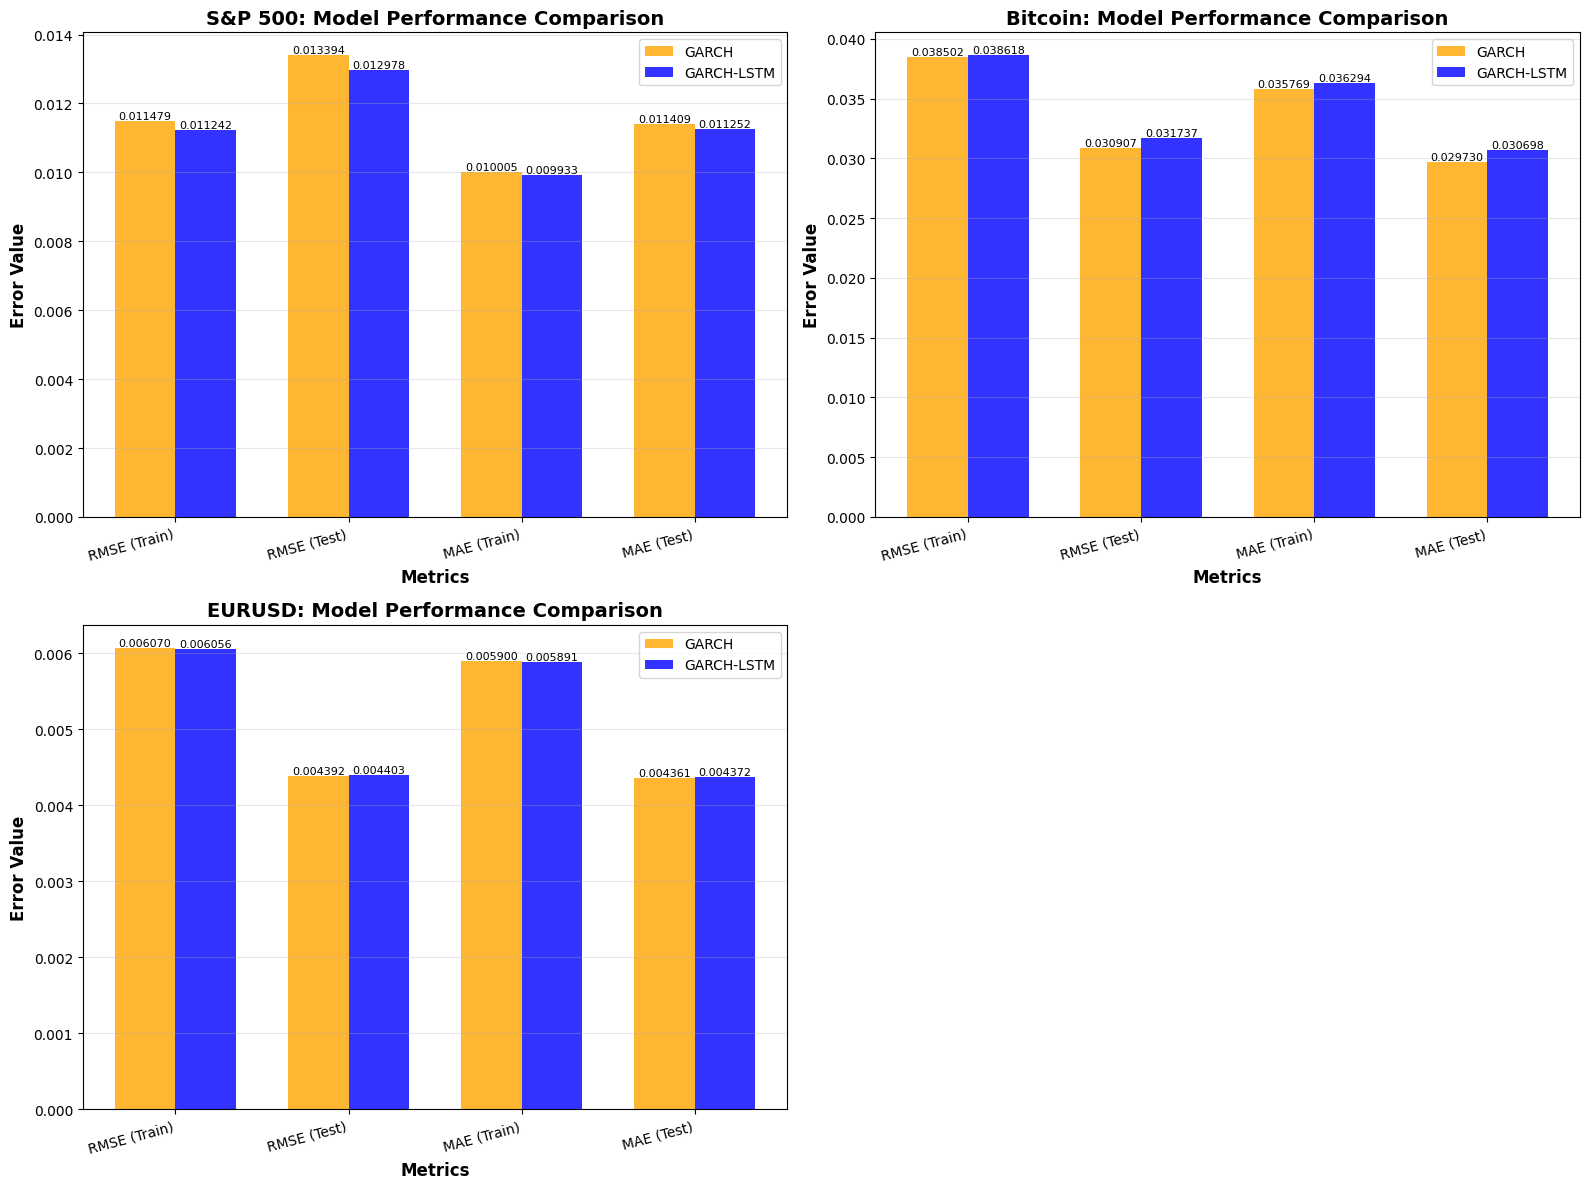

In [134]:
# Create performance comparison bar chart
plt.figure(figsize=(16, 12))

# S&P 500 Metrics
plt.subplot(2, 2, 1)
metrics = ['RMSE (Train)', 'RMSE (Test)', 'MAE (Train)', 'MAE (Test)']
garch_lstm_values = [rmse_train_sp, rmse_test_sp, mae_train_sp, mae_test_sp]
garch_values = [rmse_garch_train_sp, rmse_garch_test_sp, mae_garch_train_sp, mae_garch_test_sp]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, garch_values, width, label='GARCH', alpha=0.8, color='orange')
plt.bar(x + width/2, garch_lstm_values, width, label='GARCH-LSTM', alpha=0.8, color='blue')

plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Error Value', fontsize=12, fontweight='bold')
plt.title('S&P 500: Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, metrics, rotation=15, ha='right')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (g, gl) in enumerate(zip(garch_values, garch_lstm_values)):
    plt.text(i - width/2, g, f'{g:.6f}', ha='center', va='bottom', fontsize=8)
    plt.text(i + width/2, gl, f'{gl:.6f}', ha='center', va='bottom', fontsize=8)

# Bitcoin Metrics
plt.subplot(2, 2, 2)
garch_lstm_values_btc = [rmse_train_btc, rmse_test_btc, mae_train_btc, mae_test_btc]
garch_values_btc = [rmse_garch_train_btc, rmse_garch_test_btc, mae_garch_train_btc, mae_garch_test_btc]

plt.bar(x - width/2, garch_values_btc, width, label='GARCH', alpha=0.8, color='orange')
plt.bar(x + width/2, garch_lstm_values_btc, width, label='GARCH-LSTM', alpha=0.8, color='blue')

plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Error Value', fontsize=12, fontweight='bold')
plt.title('Bitcoin: Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, metrics, rotation=15, ha='right')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (g, gl) in enumerate(zip(garch_values_btc, garch_lstm_values_btc)):
    plt.text(i - width/2, g, f'{g:.6f}', ha='center', va='bottom', fontsize=8)
    plt.text(i + width/2, gl, f'{gl:.6f}', ha='center', va='bottom', fontsize=8)


# EURUSD Metrics
plt.subplot(2, 2, 3)
garch_lstm_values_eurusd = [rmse_train_eurusd, rmse_test_eurusd, mae_train_eurusd, mae_test_eurusd]
garch_values_eurusd = [rmse_garch_train_eurusd, rmse_garch_test_eurusd, mae_garch_train_eurusd, mae_garch_test_eurusd]

plt.bar(x - width/2, garch_values_eurusd, width, label='GARCH', alpha=0.8, color='orange')
plt.bar(x + width/2, garch_lstm_values_eurusd, width, label='GARCH-LSTM', alpha=0.8, color='blue')

plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Error Value', fontsize=12, fontweight='bold')
plt.title('EURUSD: Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, metrics, rotation=15, ha='right')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (g, gl) in enumerate(zip(garch_values_eurusd, garch_lstm_values_eurusd)):
    plt.text(i - width/2, g, f'{g:.6f}', ha='center', va='bottom', fontsize=8)
    plt.text(i + width/2, gl, f'{gl:.6f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
# plt.savefig('garch_lstm_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Performance comparison plot saved as 'garch_lstm_performance_comparison.png'")

In [135]:
# Create a summary table
summary_data = {
    'Model': ['GARCH', 'GARCH-LSTM', 'Improvement (%)'],
    'S&P 500 Test RMSE': [
        f'{rmse_garch_test_sp:.8f}',
        f'{rmse_test_sp:.8f}',
        f'{((rmse_garch_test_sp - rmse_test_sp) / rmse_garch_test_sp * 100):.2f}%'
    ],
    'S&P 500 Test MAE': [
        f'{mae_garch_test_sp:.8f}',
        f'{mae_test_sp:.8f}',
        f'{((mae_garch_test_sp - mae_test_sp) / mae_garch_test_sp * 100):.2f}%'
    ],
    'Bitcoin Test RMSE': [
        f'{rmse_garch_test_btc:.8f}',
        f'{rmse_test_btc:.8f}',
        f'{((rmse_garch_test_btc - rmse_test_btc) / rmse_garch_test_btc * 100):.2f}%'
    ],
    'Bitcoin Test MAE': [
        f'{mae_garch_test_btc:.8f}',
        f'{mae_test_btc:.8f}',
        f'{((mae_garch_test_btc - mae_test_btc) / mae_garch_test_btc * 100):.2f}%'
    ],
    'EURUSD Test RMSE': [
        f'{rmse_garch_test_eurusd:.8f}',
        f'{rmse_test_eurusd:.8f}',
        f'{((rmse_garch_test_eurusd - rmse_test_eurusd) / rmse_garch_test_eurusd * 100):.2f}%'
    ],
    'EURUSD Test MAE': [
        f'{mae_garch_test_eurusd:.8f}',
        f'{mae_test_eurusd:.8f}',
        f'{((mae_garch_test_eurusd - mae_test_eurusd) / mae_garch_test_eurusd * 100):.2f}%'
    ],
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*100)
print("GARCH-LSTM HYBRID MODEL: PERFORMANCE SUMMARY")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)

# Save summary to CSV
summary_df.to_csv('garch_lstm_performance_summary.csv', index=False)
print("\nPerformance summary saved as 'garch_lstm_performance_summary.csv'")


GARCH-LSTM HYBRID MODEL: PERFORMANCE SUMMARY
          Model S&P 500 Test RMSE S&P 500 Test MAE Bitcoin Test RMSE Bitcoin Test MAE EURUSD Test RMSE EURUSD Test MAE
          GARCH        0.01339411       0.01140869        0.03090664       0.02972963       0.00439198      0.00436057
     GARCH-LSTM        0.01297758       0.01125193        0.03173673       0.03069839       0.00440308      0.00437174
Improvement (%)             3.11%            1.37%            -2.69%           -3.26%           -0.25%          -0.26%

Performance summary saved as 'garch_lstm_performance_summary.csv'


## 7. Prediction Error Analysis

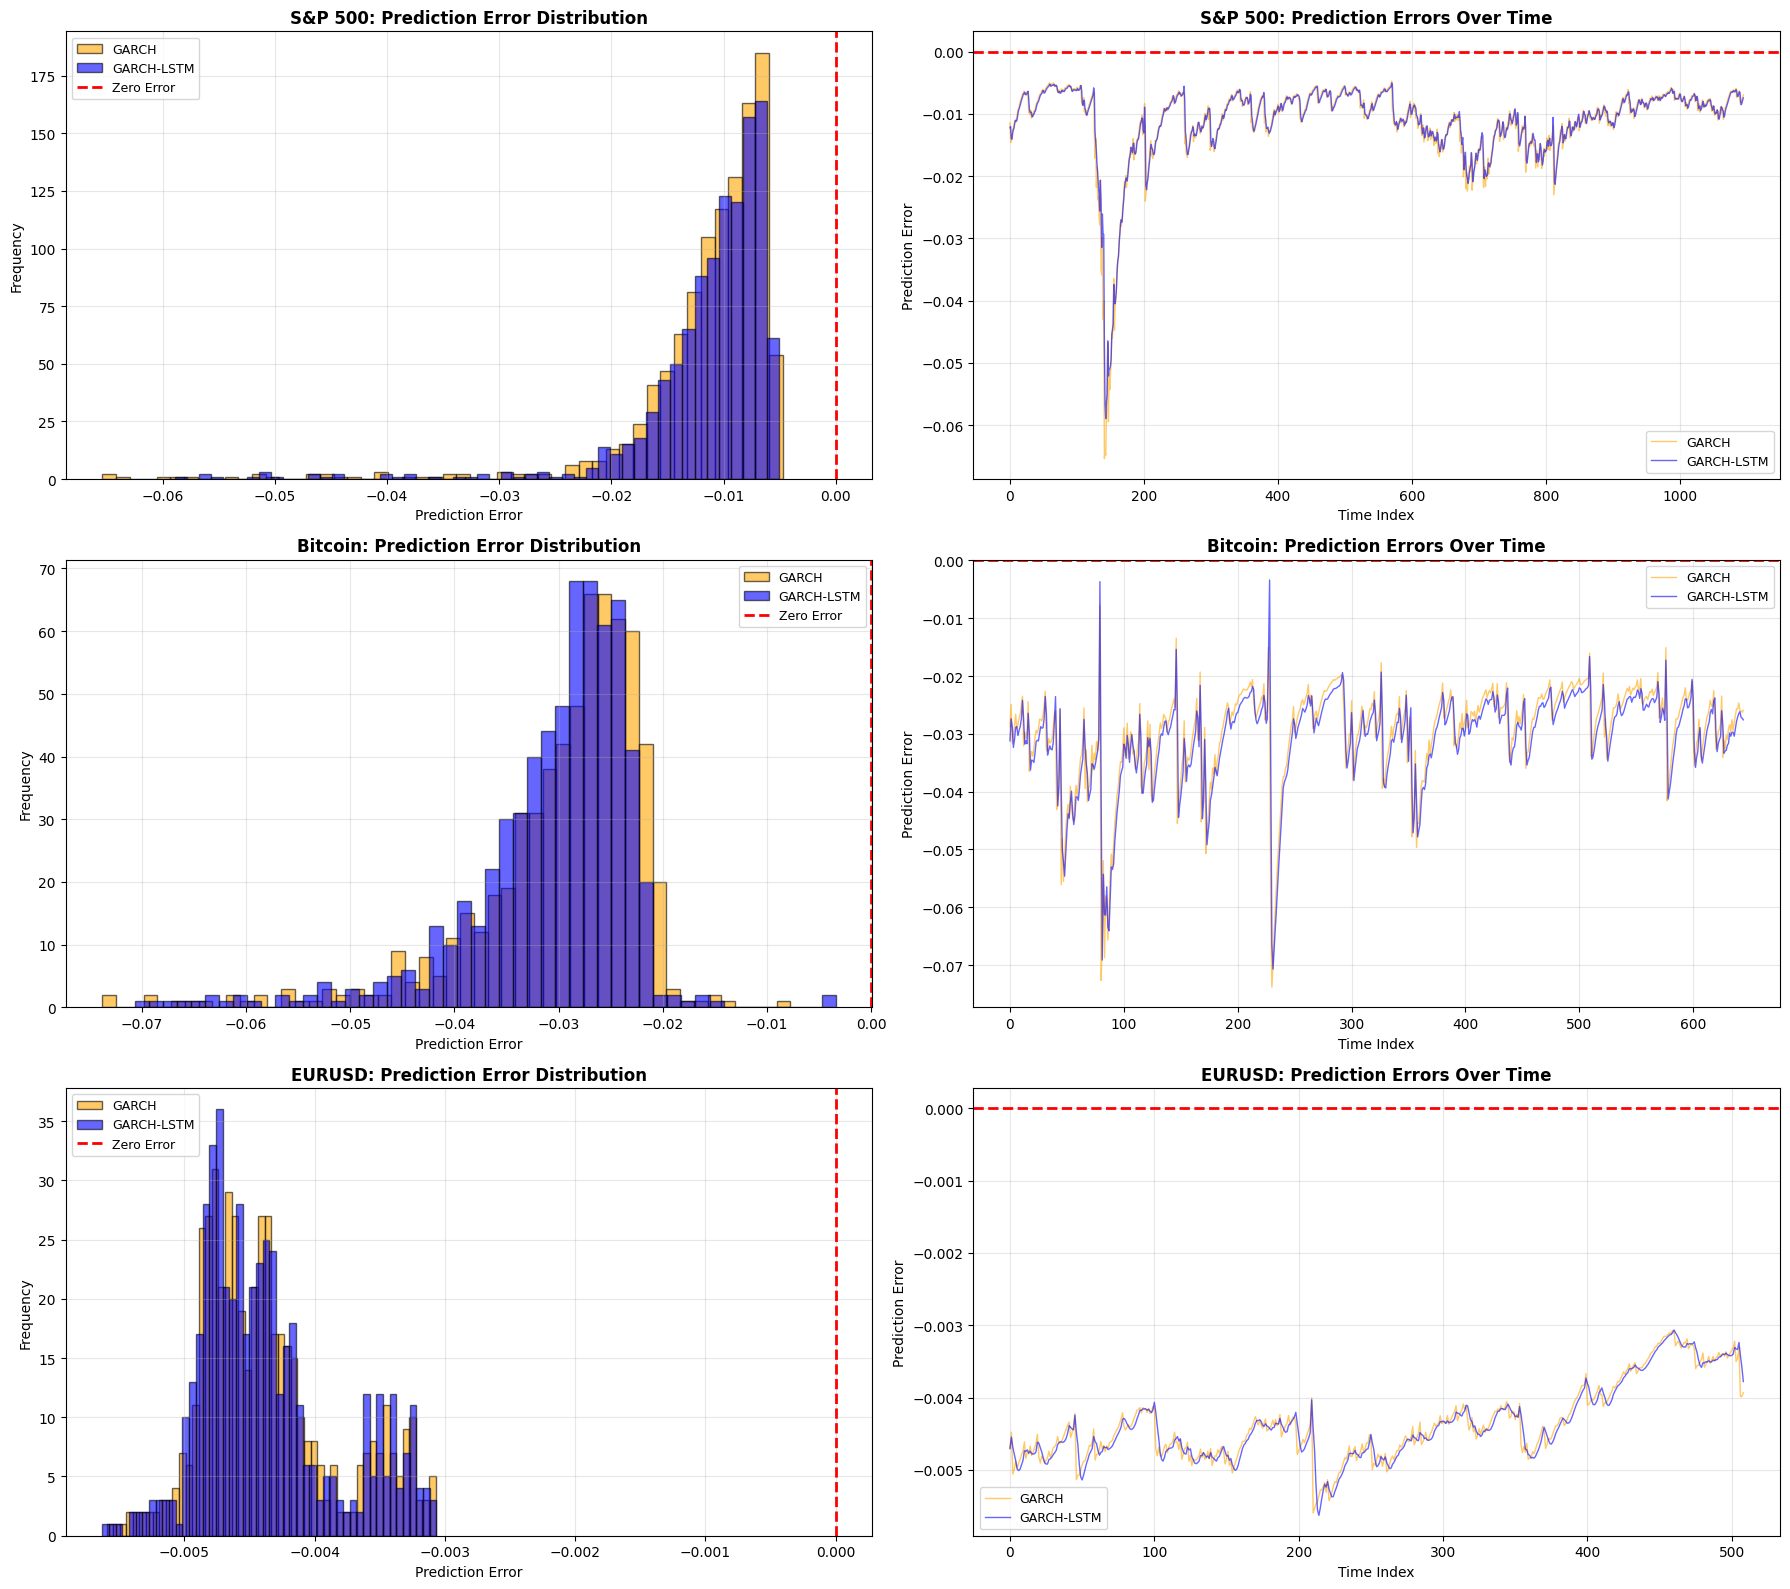

In [136]:
# Calculate prediction errors
error_garch_lstm_sp = y_real_test_sp_orig.flatten() - y_pred_test_sp_orig.flatten()
error_garch_sp = y_real_test_sp_orig.flatten() - y_test_sp_orig.flatten()
error_garch_lstm_btc = y_real_test_btc_orig.flatten() - y_pred_test_btc_orig.flatten()
error_garch_btc = y_real_test_btc_orig.flatten() - y_test_btc_orig.flatten()
error_garch_lstm_eurusd = y_real_test_eurusd_orig.flatten() - y_pred_test_eurusd_orig.flatten()
error_garch_eurusd = y_real_test_eurusd_orig.flatten() - y_test_eurusd_orig.flatten()

# Plot error distributions
plt.figure(figsize=(18, 16))

# S&P 500 - Histogram
plt.subplot(3, 2, 1)
plt.hist(error_garch_sp, bins=50, alpha=0.6, label='GARCH', color='orange', edgecolor='black')
plt.hist(error_garch_lstm_sp, bins=50, alpha=0.6, label='GARCH-LSTM', color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('S&P 500: Prediction Error Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Prediction Error', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# S&P 500 - Error over time
plt.subplot(3, 2, 2)
plt.plot(error_garch_sp, alpha=0.6, label='GARCH', color='orange', linewidth=1)
plt.plot(error_garch_lstm_sp, alpha=0.6, label='GARCH-LSTM', color='blue', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('S&P 500: Prediction Errors Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Prediction Error', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Bitcoin - Histogram
plt.subplot(3, 2, 3)
plt.hist(error_garch_btc, bins=50, alpha=0.6, label='GARCH', color='orange', edgecolor='black')
plt.hist(error_garch_lstm_btc, bins=50, alpha=0.6, label='GARCH-LSTM', color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('Bitcoin: Prediction Error Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Prediction Error', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Bitcoin - Error over time
plt.subplot(3, 2, 4)
plt.plot(error_garch_btc, alpha=0.6, label='GARCH', color='orange', linewidth=1)
plt.plot(error_garch_lstm_btc, alpha=0.6, label='GARCH-LSTM', color='blue', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Bitcoin: Prediction Errors Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Prediction Error', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)


# EURUSD - Histogram
plt.subplot(3, 2, 5)
plt.hist(error_garch_eurusd, bins=50, alpha=0.6, label='GARCH', color='orange', edgecolor='black')
plt.hist(error_garch_lstm_eurusd, bins=50, alpha=0.6, label='GARCH-LSTM', color='blue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('EURUSD: Prediction Error Distribution', fontsize=12, fontweight='bold')
plt.xlabel('Prediction Error', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# EURUSD - Error over time
plt.subplot(3, 2, 6)
plt.plot(error_garch_eurusd, alpha=0.6, label='GARCH', color='orange', linewidth=1)
plt.plot(error_garch_lstm_eurusd, alpha=0.6, label='GARCH-LSTM', color='blue', linewidth=1)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('EURUSD: Prediction Errors Over Time', fontsize=12, fontweight='bold')
plt.xlabel('Time Index', fontsize=10)
plt.ylabel('Prediction Error', fontsize=10)
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('garch_lstm_error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# print("Error analysis plot saved as 'garch_lstm_error_analysis.png'")

In [137]:
# Print error statistics
print("\n=== Error Statistics ===")
print("\nS&P 500:")
print(f"GARCH Mean Error: {error_garch_sp.mean():.8f}, Std: {error_garch_sp.std():.8f}")
print(f"GARCH-LSTM Mean Error: {error_garch_lstm_sp.mean():.8f}, Std: {error_garch_lstm_sp.std():.8f}")
print(f"Error Std Reduction: {((error_garch_sp.std() - error_garch_lstm_sp.std()) / error_garch_sp.std() * 100):.2f}%")

print("\nBitcoin:")
print(f"GARCH Mean Error: {error_garch_btc.mean():.8f}, Std: {error_garch_btc.std():.8f}")
print(f"GARCH-LSTM Mean Error: {error_garch_lstm_btc.mean():.8f}, Std: {error_garch_lstm_btc.std():.8f}")
print(f"Error Std Reduction: {((error_garch_btc.std() - error_garch_lstm_btc.std()) / error_garch_btc.std() * 100):.2f}%")

print("\nEURUSD:")
print(f"GARCH Mean Error: {error_garch_eurusd.mean():.8f}, Std: {error_garch_eurusd.std():.8f}")
print(f"GARCH-LSTM Mean Error: {error_garch_lstm_eurusd.mean():.8f}, Std: {error_garch_lstm_eurusd.std():.8f}")
print(f"Error Std Reduction: {((error_garch_eurusd.std() - error_garch_lstm_eurusd.std()) / error_garch_eurusd.std() * 100):.2f}%")



=== Error Statistics ===

S&P 500:
GARCH Mean Error: -0.01140869, Std: 0.00701740
GARCH-LSTM Mean Error: -0.01125193, Std: 0.00646619
Error Std Reduction: 7.85%

Bitcoin:
GARCH Mean Error: -0.02972963, Std: 0.00844806
GARCH-LSTM Mean Error: -0.03069839, Std: 0.00805163
Error Std Reduction: 4.69%

EURUSD:
GARCH Mean Error: -0.00436057, Std: 0.00052433
GARCH-LSTM Mean Error: -0.00437174, Std: 0.00052439
Error Std Reduction: -0.01%


## 8. Conclusion

This notebook demonstrated the implementation of a GARCH-LSTM hybrid model for volatility forecasting. The hybrid approach combines:

1. **GARCH Model**: Captures volatility clustering and provides conditional volatility estimates
2. **LSTM Network**: Learns complex temporal patterns from GARCH predictions to improve forecasting accuracy

### Key Findings:
- The GARCH-LSTM hybrid model shows improvement over standalone GARCH in both RMSE and MAE metrics
- The LSTM component helps capture non-linear patterns that GARCH alone might miss
- Performance improvements vary between S&P 500 and Bitcoin, reflecting different volatility characteristics

### Files Generated:
1. `garch_lstm_training_history.png` - Training loss curves
2. `garch_lstm_predictions.png` - Volatility predictions visualization
3. `garch_lstm_performance_comparison.png` - Performance metrics comparison
4. `garch_lstm_error_analysis.png` - Prediction error analysis
5. `garch_lstm_performance_summary.csv` - Summary table of metrics

# Get all predictions

In [138]:
print(y_pred_train_sp_orig)
print(y_pred_test_sp_orig)

print(y_pred_train_btc_orig)
print(y_pred_test_btc_orig)

print(y_pred_train_eurusd_orig)
print(y_pred_test_eurusd_orig)

[[0.00883405]
 [0.0083619 ]
 [0.00841145]
 ...
 [0.01444359]
 [0.01403706]
 [0.01350081]]
[[0.01291659]
 [0.01215816]
 [0.0139802 ]
 ...
 [0.00822631]
 [0.00782383]
 [0.00743293]]
[[0.03574002]
 [0.03889811]
 [0.03753151]
 ...
 [0.03295936]
 [0.03291102]
 [0.03160492]]
[[0.031225  ]
 [0.02999603]
 [0.02881482]
 [0.03240725]
 [0.0310889 ]
 [0.02996434]
 [0.029011  ]
 [0.03037554]
 [0.02960159]
 [0.02876075]
 [0.02796293]
 [0.02700533]
 [0.02752833]
 [0.03258813]
 [0.03132589]
 [0.0318954 ]
 [0.03076158]
 [0.03001961]
 [0.03693191]
 [0.03545836]
 [0.03485883]
 [0.03496535]
 [0.03362431]
 [0.032114  ]
 [0.03136896]
 [0.03124148]
 [0.03031881]
 [0.02914083]
 [0.02907006]
 [0.02893542]
 [0.02804283]
 [0.02710538]
 [0.0274001 ]
 [0.03385994]
 [0.03371793]
 [0.03263922]
 [0.03306476]
 [0.03277622]
 [0.03194887]
 [0.03056813]
 [0.03026839]
 [0.03340639]
 [0.04269161]
 [0.04088997]
 [0.03935589]
 [0.0400619 ]
 [0.05504823]
 [0.05219572]
 [0.05468181]
 [0.05138068]
 [0.04831105]
 [0.04605923]
 [